<a href="https://colab.research.google.com/github/eccardoso/ML/blob/main/ML_Produ%C3%A7%C3%A3o_Leite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo preditivo para classificação de produção de leite de cabras baseado em dados de Controle Leiteiro

###Objetivo: Ao nascer um filhote (fêmea) poder classificar em que grupo produtivo se encontra para tomada de decisão do produtor*

## Variáveis utilizadas:
Brinco_Pai=Identificação do pai

Brinco_Mae=Identificação da mãe

Brinco_Animal=Identificação do animal ordenhado

Media_pai=Media de produção de leite de todas as filhas

Media_mae=Media de produção de leite da mãe

Media_prod=Media de produção do animal ordenhado no controle

Idade=Idade da cabra em lactação

DEL=Dias em lactação

Ordem_lac=Ordem de lactação (exp: 1 primeiro parto, 2 segundo parto etc)

Classe (alvo)=Classe que o animal se encontra
1.   Produção > 3 litros
2.   Produção entre 2 e 3 litros
1.   Produção entre 1 e 2 litros
2.   Produção < 1 litro

In [390]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos

## Carga do Dataset

In [391]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/eccardoso/ML/main/BASE_ML_v2.csv"

# Lê o arquivo
datasetori = pd.read_csv(url, delimiter=';')

# Converte as variaveis para float
datasetori["Media_Mae"]=pd.to_numeric(datasetori["Media_Mae"],errors='coerce')
datasetori["Media_Prod"]=pd.to_numeric(datasetori["Media_Mae"],errors='coerce')

# Eliminando colunas não relevantes para análise e mostrando as primeiras linhas
dataset=datasetori.drop(['Brinco_Pai','Brinco_Mae','Brinco_Animal','Media_Prod'],axis='columns')
dataset.head()

,Media_Pai,Media_Mae,Idade,Ordem_Lac,DEL,Classe
0,1.66,1.37,4,1,842,3
1,1.66,1.37,6,2,350,4
2,1.58,1.88,2,1,188,3
3,1.58,1.88,3,2,188,2
4,1.58,1.09,2,1,276,4


In [392]:
# Mostra as informações do dataset
print(dataset.info())
print(dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Media_Pai  139 non-null    float64
 1   Media_Mae  139 non-null    float64
 2   Idade      139 non-null    int64  
 3   Ordem_Lac  139 non-null    int64  
 4   DEL        139 non-null    int64  
 5   Classe     139 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 6.6 KB
None
(139, 6)


## Separação em conjunto de treino e conjunto de teste com holdout

In [393]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 3 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:5]
y = array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

print (X)

[[1.66e+00 1.37e+00 4.00e+00 1.00e+00 8.42e+02]
 [1.66e+00 1.37e+00 6.00e+00 2.00e+00 3.50e+02]
 [1.58e+00 1.88e+00 2.00e+00 1.00e+00 1.88e+02]
 [1.58e+00 1.88e+00 3.00e+00 2.00e+00 1.88e+02]
 [1.58e+00 1.09e+00 2.00e+00 1.00e+00 2.76e+02]
 [1.58e+00 1.09e+00 3.00e+00 2.00e+00 1.85e+02]
 [1.46e+00 1.09e+00 5.00e+00 1.00e+00 2.48e+02]
 [1.46e+00 1.09e+00 6.00e+00 2.00e+00 2.66e+02]
 [1.46e+00 1.13e+00 3.00e+00 1.00e+00 1.44e+02]
 [1.46e+00 1.13e+00 4.00e+00 2.00e+00 1.90e+02]
 [1.76e+00 1.13e+00 2.00e+00 1.00e+00 2.28e+02]
 [1.76e+00 1.13e+00 4.00e+00 2.00e+00 2.09e+02]
 [1.76e+00 1.13e+00 2.00e+00 1.00e+00 1.90e+02]
 [1.76e+00 1.13e+00 3.00e+00 2.00e+00 2.97e+02]
 [1.76e+00 1.13e+00 5.00e+00 3.00e+00 2.70e+02]
 [1.66e+00 1.30e+00 3.00e+00 1.00e+00 2.71e+02]
 [1.66e+00 1.30e+00 4.00e+00 2.00e+00 1.67e+02]
 [1.66e+00 1.30e+00 5.00e+00 3.00e+00 1.66e+02]
 [1.76e+00 1.20e+00 3.00e+00 1.00e+00 3.64e+02]
 [1.76e+00 1.20e+00 5.00e+00 2.00e+00 4.57e+02]
 [1.69e+00 1.20e+00 5.00e+00 1.00e+00 1.

##Identificação de variáveis relevantes

In [394]:
# SelectKBest

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=3)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset.columns[0:5])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset.columns[0:5]))
#print (X)


Número original de atributos: 5

Número reduzido de atributos: 3

Atributos Originais: Index(['Media_Pai', 'Media_Mae', 'Idade', 'Ordem_Lac', 'DEL'], dtype='object')

Scores dos Atributos Originais: [0.053 1.063 0.226 1.343 1.387]

Atributos Selecionados: ['Media_Mae' 'Ordem_Lac' 'DEL']


In [395]:
# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset.columns[0:5])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)


Atributos Originais: Index(['Media_Pai', 'Media_Mae', 'Idade', 'Ordem_Lac', 'DEL'], dtype='object')
[0.13  0.329 0.099 0.09  0.352]


### Criação e avaliação de modelos: linha base

LR: 0.550000 (0.065713)
KNN: 0.459091 (0.122727)
CART: 0.513636 (0.134917)
NB: 0.495455 (0.059091)
SVM: 0.577273 (0.050000)
Bagging: 0.575000 (0.137889)
RF: 0.540152 (0.149765)
ET: 0.513636 (0.099690)
Ada: 0.431061 (0.138885)
GB: 0.548485 (0.131006)
Voting: 0.559091 (0.070564)


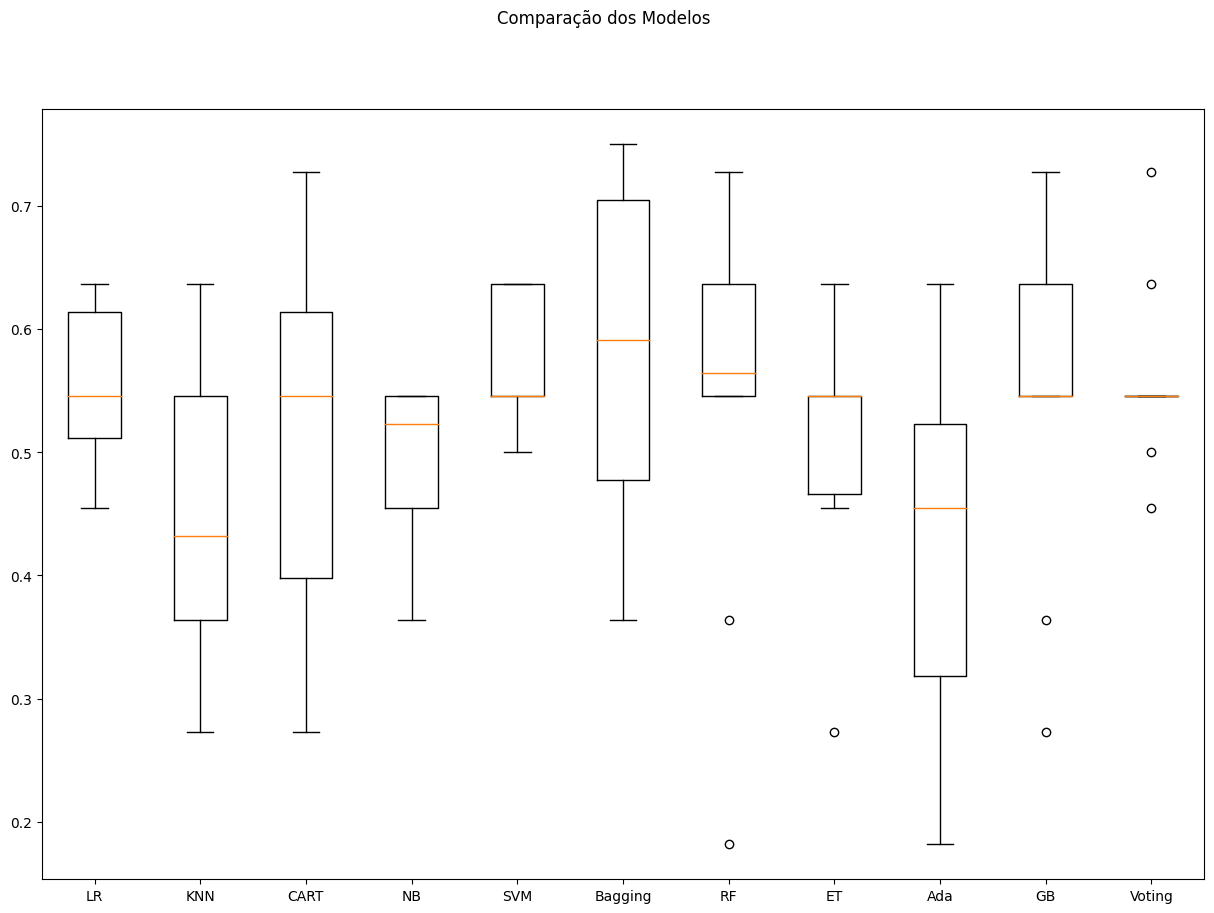

In [396]:
np.random.seed(3) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=100)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.550 (0.066)
KNN-orig: 0.459 (0.123)
CART-orig: 0.514 (0.135)
NB-orig: 0.495 (0.059)
SVM-orig: 0.577 (0.050)
Bag-orig: 0.575 (0.138)
RF-orig: 0.540 (0.150)
ET-orig: 0.514 (0.100)
Ada-orig: 0.431 (0.139)
GB-orig: 0.548 (0.131)
Vot-orig: 0.559 (0.071)
LR-padr: 0.550 (0.105)
KNN-padr: 0.467 (0.140)
CART-padr: 0.523 (0.123)
NB-padr: 0.495 (0.059)
SVM-padr: 0.568 (0.062)
Bag-padr: 0.584 (0.126)
RF-padr: 0.566 (0.137)
ET-padr: 0.495 (0.082)
Ada-padr: 0.431 (0.139)
GB-padr: 0.557 (0.146)
Vot-padr: 0.559 (0.108)
LR-norm: 0.586 (0.052)
KNN-norm: 0.495 (0.136)
CART-norm: 0.504 (0.160)
NB-norm: 0.495 (0.059)
SVM-norm: 0.586 (0.052)
Bag-norm: 0.584 (0.133)
RF-norm: 0.585 (0.103)
ET-norm: 0.495 (0.129)
Ada-norm: 0.440 (0.131)
GB-norm: 0.548 (0.150)
Vot-norm: 0.586 (0.052)


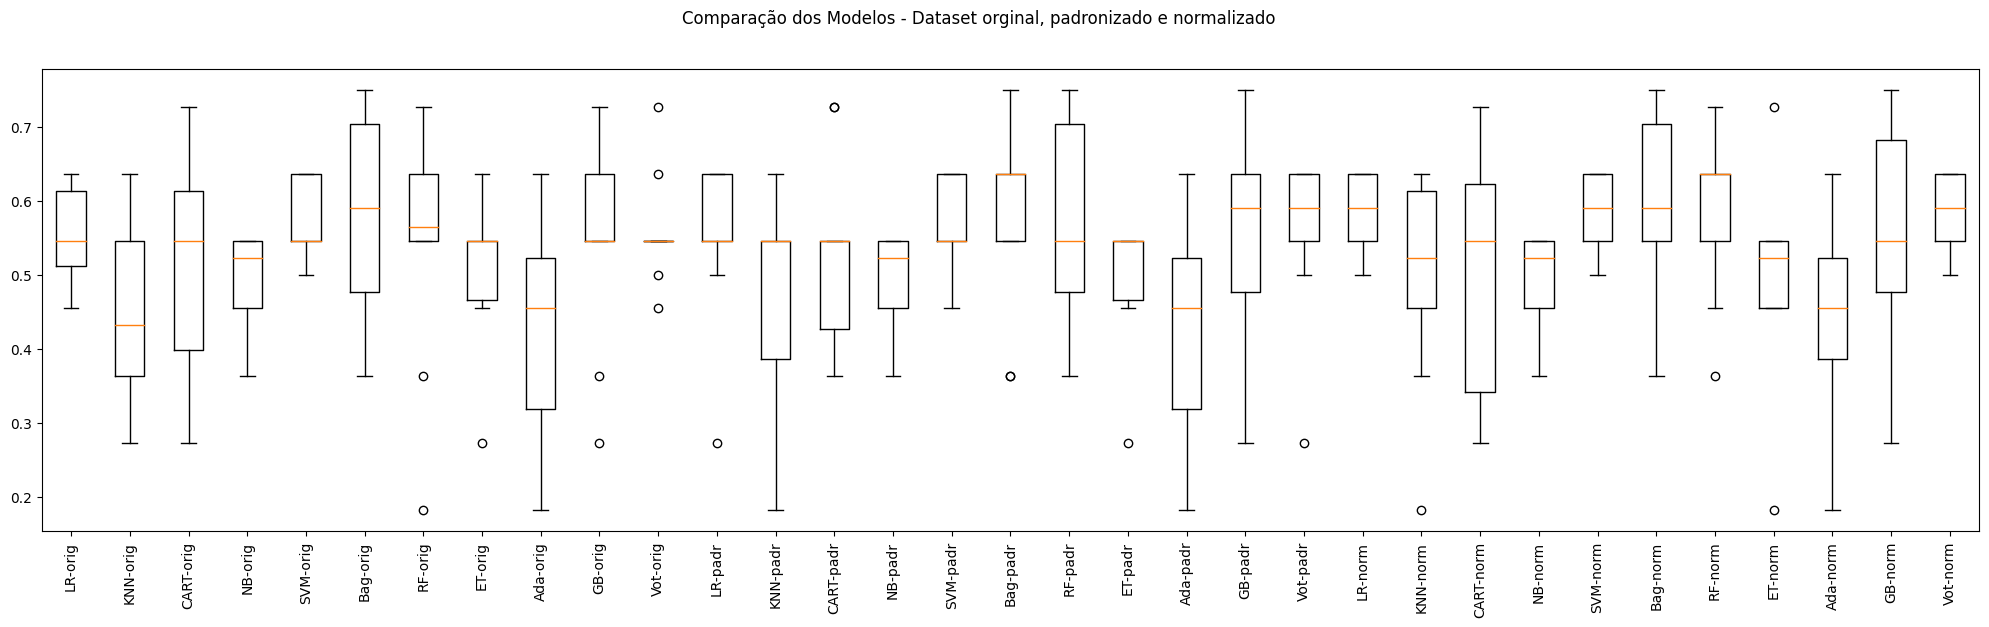

In [397]:
np.random.seed(3) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=100))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [398]:
# Tuning LR - Escolhido LR normalizado pelo boxplot acima (Menor dispersão e mediana mais equilibrada)

std_slc = StandardScaler()
pca=decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()
pipe = Pipeline(steps=[('std_slc', std_slc),('pca', pca),('logistic_Reg', logistic_Reg)])
n_components = list(range(1,X.shape[1]+1,1))
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
parameters = dict(pca__n_components=n_components,logistic_Reg__C=C,logistic_Reg__penalty=penalty)
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, y)

print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l2
Best C: 0.2682695795279725
Best Number Of Components: 3

LogisticRegression(C=0.2682695795279725)


In [399]:
#print (X)

### Seleção de características

In [400]:
# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=100)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=3)
fit = rfe.fit(X, y)

# Print dos resultados
print("Atributos Originais:", dataset.columns[0:5])

# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=dataset.columns[0:5]))

Atributos Originais: Index(['Media_Pai', 'Media_Mae', 'Idade', 'Ordem_Lac', 'DEL'], dtype='object')

Atributos Selecionados: [ True  True False  True False]

Ranking de atributos: [1 1 2 1 3]

Qtd de melhores Atributos: 3

Nomes dos Atributos Selecionados: ['Media_Pai' 'Media_Mae' 'Ordem_Lac']


In [401]:
# Eliminando colunas não relevantes para análise e mostrando as primeiras linhas
dataset=datasetori.drop(['Brinco_Pai','Brinco_Mae','Idade','DEL','Brinco_Animal','Media_Prod'],axis='columns')
dataset.head()

,Media_Pai,Media_Mae,Ordem_Lac,Classe
0,1.66,1.37,1,3
1,1.66,1.37,2,4
2,1.58,1.88,1,3
3,1.58,1.88,2,2
4,1.58,1.09,1,4


## Novo Conjunto de Treino utilizando as váriaveis relevantes ['Media_Pai' 'Media_Mae' 'Ordem_Lac']

In [402]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 3 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:3]
y = array[:,3]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

dataset.head()

,Media_Pai,Media_Mae,Ordem_Lac,Classe
0,1.66,1.37,1,3
1,1.66,1.37,2,4
2,1.58,1.88,1,3
3,1.58,1.88,2,2
4,1.58,1.09,1,4


## Finalização do Modelo

In [403]:
# Avaliação do modelo com o conjunto de testes
# Preparação do modelo
# Escolhida 3 variaveis para obtenção do modelo ['Media_Pai' 'Media_Mae' 'Ordem_Lac']

scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino

reg_log = ('LR', LogisticRegression(max_iter=100,C=0.2682695795279725,penalty='l2'))
model=Pipeline([min_max_scaler, reg_log])
model.fit(rescaledX, y_train)
#print (X_train)
#print (y_train)

# Estimativa da acurácia no conjunto de teste
#scaler = StandardScaler().fit(X_test) # ajuste do scaler com o conjunto de treino
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
#print (X_test)
#print (y_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))
print (predictions)

0.5714285714285714
[[ 0  0  1  0]
 [ 0  0  7  0]
 [ 0  0 16  0]
 [ 0  0  4  0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         7
         3.0       0.57      1.00      0.73        16
         4.0       0.00      0.00      0.00         4

    accuracy                           0.57        28
   macro avg       0.14      0.25      0.18        28
weighted avg       0.33      0.57      0.42        28

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3.]


In [404]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('LR', LogisticRegression(C=0.2682695795279725))])

## Simulando a aplicação do modelo em dados não vistos

In [407]:
# Novos dados - não sabemos a classe!
data = {'Media_Pai': [1.76,1.66],
        'Media_Mae': [1.13,1.37],
        'Ordem_Lac': [2,2]
        }

atributos = ['Media_Pai','Media_Mae','Ordem_Lac']
entrada = pd.DataFrame(data, columns=atributos)
print(entrada)

array_entrada = entrada.values
X_entrada=array_entrada

print(entrada.info())

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
#print(X_entrada)

   Media_Pai  Media_Mae  Ordem_Lac
0       1.76       1.13          2
1       1.66       1.37          2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Media_Pai  2 non-null      float64
 1   Media_Mae  2 non-null      float64
 2   Ordem_Lac  2 non-null      int64  
dtypes: float64(2), int64(1)
memory usage: 176.0 bytes
None


In [409]:
# Predição de classes dos dados de entrada
# Deveria ser classe 3 e 2
saidas = model.predict(rescaledEntradaX)
print(saidas)

[3. 3.]
